In [3]:
#Importing Packages
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score



In [4]:
#Getting the data
phishing_data = pd.read_csv('cleaned-outliers.csv')
phishing_data.head()


,NoOfImage,NoOfSelfRef,LineOfCode,NoOfExternalRef,label
0,0.003796,0.004344,0.001256,0.004506,1
1,0.005583,0.001424,0.001392,0.007886,1
2,0.001117,0.001533,0.001050,0.000182,1
3,0.000335,0.000803,0.014354,0.001127,1
4,0.027244,0.002628,0.013751,0.003089,1


In [7]:
# Define the model and hyperparameter grid
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42,early_stopping=True)
param_grid = {
    'hidden_layer_sizes': [(100,),(50,),(50,30)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001,0.001, 0.01],
}


#Getting the parameters
params = nn_model.get_params()
# Print the parameters
for param, value in params.items():
    print(f"{param}: {value}")


activation: relu
alpha: 0.0001
batch_size: auto
beta_1: 0.9
beta_2: 0.999
early_stopping: True
epsilon: 1e-08
hidden_layer_sizes: (100,)
learning_rate: constant
learning_rate_init: 0.001
max_fun: 15000
max_iter: 500
momentum: 0.9
n_iter_no_change: 10
nesterovs_momentum: True
power_t: 0.5
random_state: 42
shuffle: True
solver: adam
tol: 0.0001
validation_fraction: 0.1
verbose: False
warm_start: False


In [9]:
# Features and target
features = ['NoOfImage', 'NoOfSelfRef', 'LineOfCode', 'NoOfExternalRef']
target = 'label'

In [11]:
# Split the data into features (X) and target (y)
X = phishing_data[features]
y = phishing_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.model_selection import GridSearchCV
scaler = StandardScaler()

# Standardize the entire dataset before tuning (only if `X` is not pre-scaled)
X_scaled = scaler.fit_transform(X)


# Perform hyperparameter tuning with cross-validation
grid_search = GridSearchCV(nn_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X,y)

# Best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 30)}
Best Score: 0.9821667050738524


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize lists to store results for each fold
testaccuracies = []
testconfusion_matrices = []
testclassification_reports = []

trainaccuracies = []
trainconfusion_matrices = []
trainclassification_reports = []

# Stratified K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the data for each fold
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Use the best model found by GridSearchCV
    best_nn = grid_search.best_estimator_
    best_nn.fit(X_train_scaled, y_train)

    # Make predictions
    nn_predictionstrain = best_nn.predict(X_train_scaled)
    nn_predictionstest = best_nn.predict(X_test_scaled)

    # Evaluate the model for the current fold
    testaccuracies.append(best_nn.score(X_test_scaled, y_test))  # Accuracy
    testconfusion_matrices.append(confusion_matrix(y_test, nn_predictionstest))
    testclassification_reports.append(classification_report(y_test, nn_predictionstest, output_dict=True))

    trainaccuracies.append(best_nn.score(X_train_scaled, y_train))  # Accuracy
    trainconfusion_matrices.append(confusion_matrix(y_train, nn_predictionstrain))
    trainclassification_reports.append(classification_report(y_train, nn_predictionstrain, output_dict=True))

# Print the mean accuracy
print(f"(Testing) Mean Accuracy: {np.mean(testaccuracies):.4f}")
print(f"(Training) Mean Accuracy: {np.mean(trainaccuracies):.4f}")

# Print the mean confusion matrix
test_mean_confusion_matrix = np.mean(testconfusion_matrices, axis=0)
print(f"(Testing) Mean Confusion Matrix: \n{test_mean_confusion_matrix}")

train_mean_confusion_matrix = np.mean(trainconfusion_matrices, axis=0)
print(f"(Training) Mean Confusion Matrix: \n{train_mean_confusion_matrix}")

# Compute average classification report manually for Class 0
testavg_precision_0 = np.mean([report['0']['precision'] for report in testclassification_reports])
testavg_recall_0 = np.mean([report['0']['recall'] for report in testclassification_reports])
testavg_f1_0 = np.mean([report['0']['f1-score'] for report in testclassification_reports])

trainavg_precision_0 = np.mean([report['0']['precision'] for report in trainclassification_reports])
trainavg_recall_0 = np.mean([report['0']['recall'] for report in trainclassification_reports])
trainavg_f1_0 = np.mean([report['0']['f1-score'] for report in trainclassification_reports])

# Print the average classification report for Class 0
print(f"\nAverage Classification Report (Class 0 Testing):")
print(f"Precision: {testavg_precision_0:.4f}")
print(f"Recall: {testavg_recall_0:.4f}")
print(f"F1-Score: {testavg_f1_0:.4f}")

print(f"\nAverage Classification Report (Class 0 Training):")
print(f"Precision: {trainavg_precision_0:.4f}")
print(f"Recall: {trainavg_recall_0:.4f}")
print(f"F1-Score: {trainavg_f1_0:.4f}")

# Compute average classification report manually for Class 1
testavg_precision = np.mean([report['1']['precision'] for report in testclassification_reports])
testavg_recall = np.mean([report['1']['recall'] for report in testclassification_reports])
testavg_f1 = np.mean([report['1']['f1-score'] for report in testclassification_reports])

trainavg_precision = np.mean([report['1']['precision'] for report in trainclassification_reports])
trainavg_recall = np.mean([report['1']['recall'] for report in trainclassification_reports])
trainavg_f1 = np.mean([report['1']['f1-score'] for report in trainclassification_reports])

# Print the average classification report for Class 1
print(f"\nAverage Classification Report (Class 1 Testing):")
print(f"Precision: {testavg_precision:.4f}")
print(f"Recall: {testavg_recall:.4f}")
print(f"F1-Score: {testavg_f1:.4f}")

print(f"\nAverage Classification Report (Class 1 Training):")
print(f"Precision: {trainavg_precision:.4f}")
print(f"Recall: {trainavg_recall:.4f}")
print(f"F1-Score: {trainavg_f1:.4f}")

# Optionally, print the full classification report for each fold
print(f"\nFull Classification Report (averaged test):")
for i in range(len(testclassification_reports)):
    print(f"Fold {i+1}:\n{testclassification_reports[i]}")

print(f"\nFull Classification Report (averaged training):")
for i in range(len(trainclassification_reports)):
    print(f"Fold {i+1}:\n{trainclassification_reports[i]}")


(Testing) Mean Accuracy: 0.9865
(Training) Mean Accuracy: 0.9867
(Testing) Mean Confusion Matrix: 
[[33028.           620.33333333]
 [  440.33333333 44509.66666667]]
(Training) Mean Confusion Matrix: 
[[66057.33333333  1239.33333333]
 [  858.66666667 89041.33333333]]

Average Classification Report (Class 0 Testing):
Precision: 0.9868
Recall: 0.9816
F1-Score: 0.9842

Average Classification Report (Class 0 Training):
Precision: 0.9872
Recall: 0.9816
F1-Score: 0.9844

Average Classification Report (Class 1 Testing):
Precision: 0.9863
Recall: 0.9902
F1-Score: 0.9882

Average Classification Report (Class 1 Training):
Precision: 0.9863
Recall: 0.9904
F1-Score: 0.9884

Full Classification Report (averaged test):
Fold 1:
{'0': {'precision': 0.98560443490701, 'recall': 0.9827632321911498, 'f1-score': 0.9841817830091815, 'support': 33649.0}, '1': {'precision': 0.9871245587941483, 'recall': 0.9892547274749722, 'f1-score': 0.9881884951720613, 'support': 44950.0}, 'accuracy': 0.986475654906551, 'ma

In [15]:
'''
# Standardize the features
scaler = StandardScaler()

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results for each fold
accuracies = []
confusion_matrices = []
classification_reports = []

# Stratified K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    X_train, x_test= X.iloc[train_index], X.iloc[test_index]

    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the data for each fold
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the Neural Network Classifier
    nn_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
    nn_model.fit(X_train_scaled, y_train)

    # Make predictions
    nn_predictions = nn_model.predict(X_test_scaled)

    # Evaluate the model for the current fold
    accuracies.append(nn_model.score(X_test_scaled, y_test))  # Accuracy
    confusion_matrices.append(confusion_matrix(y_test, nn_predictions))
    classification_reports.append(classification_report(y_test, nn_predictions, output_dict=True))

# Print the mean accuracy
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")

# Print the mean confusion matrix
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
print(f"Mean Confusion Matrix: \n{mean_confusion_matrix}")

# Compute average classification report manually
avg_precision = np.mean([report['1']['precision'] for report in classification_reports])
avg_recall = np.mean([report['1']['recall'] for report in classification_reports])
avg_f1 = np.mean([report['1']['f1-score'] for report in classification_reports])

# Print the average classification report
print(f"\nAverage Classification Report (Class 1):")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1-Score: {avg_f1:.4f}")

# Optionally, print the full classification report for class 0 and 1
print(f"\nFull Classification Report (averaged):")
for i in range(len(classification_reports)):
    print(f"Fold {i+1}:\n{classification_reports[i]}")

'''

'\n# Standardize the features\nscaler = StandardScaler()\n\n# Initialize StratifiedKFold\nkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n# Initialize lists to store results for each fold\naccuracies = []\nconfusion_matrices = []\nclassification_reports = []\n\n# Stratified K-Fold Cross-Validation\nfor train_index, test_index in kf.split(X, y):\n    X_train, x_test= X.iloc[train_index], X.iloc[test_index]\n\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n\n    # Standardize the data for each fold\n    X_train_scaled = scaler.fit_transform(X_train)\n    X_test_scaled = scaler.transform(X_test)\n\n    # Train the Neural Network Classifier\n    nn_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)\n    nn_model.fit(X_train_scaled, y_train)\n\n    # Make predictions\n    nn_predictions = nn_model.predict(X_test_scaled)\n\n    # Evaluate the model for the current fold\n    accuracies.append(nn_model.score(X_test_scaled, y_test))

In [16]:
'''#Neural Network Classifier
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

nn_model.fit(X_train_scaled, y_train)

nn_predictions = nn_model.predict(X_test_scaled)


print("Neural Network Classifier Results:")

print(f"Accuracy: {accuracy_score(y_test, nn_predictions)}")
print("Neural Network Cross-Validation Accuracy:", nn_scores.mean())
print(classification_report(y_test, nn_predictions))'''

#Block comment of original code

'#Neural Network Classifier\nnn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)\n\nnn_model.fit(X_train_scaled, y_train)\n\nnn_predictions = nn_model.predict(X_test_scaled)\n\n\nprint("Neural Network Classifier Results:")\n\nprint(f"Accuracy: {accuracy_score(y_test, nn_predictions)}")\nprint("Neural Network Cross-Validation Accuracy:", nn_scores.mean())\nprint(classification_report(y_test, nn_predictions))'

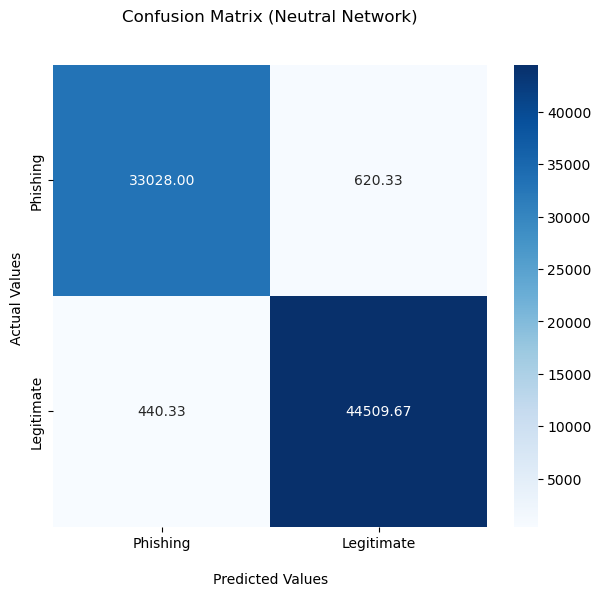

In [46]:
fig, ax = plt.subplots(figsize=(7,6))

ax = sns.heatmap(test_mean_confusion_matrix, annot=True, cmap='Blues', fmt='.2f')

ax.set_title('Confusion Matrix (Neutral Network)\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Adjust tick labels to be descriptive
ax.xaxis.set_ticklabels(['Phishing', 'Legitimate'], fontsize=10)
ax.yaxis.set_ticklabels(['Phishing', 'Legitimate'], fontsize=10)

## Display the visualization of the Confusion Matrix.
plt.show()

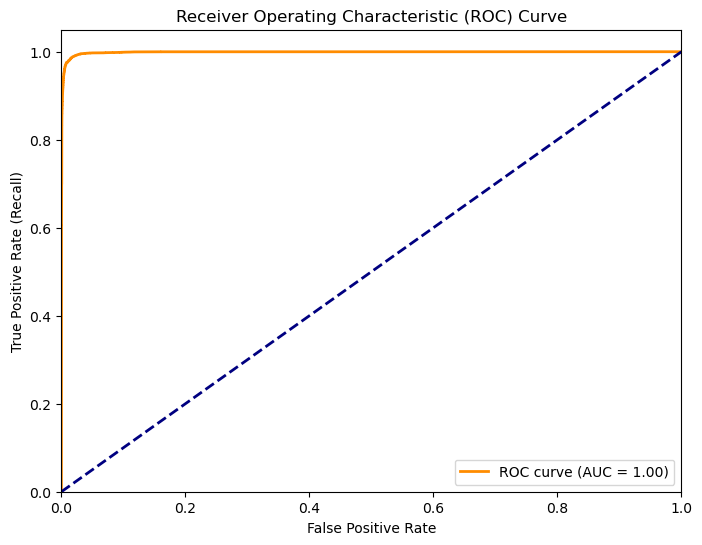

In [19]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for ROC curve
y_prob_test = best_nn.predict_proba(X_test_scaled)[:, 1]  # Only take probabilities for class 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

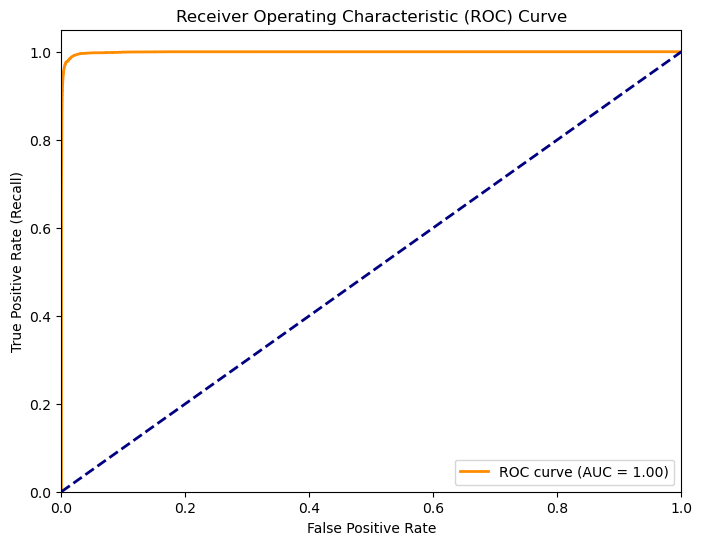

In [20]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for ROC curve
y_prob_train = best_nn.predict_proba(X_train_scaled)[:, 1]  # Only take probabilities for class 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()